# Life Expectancy Prediction with XGBoost

This notebook analyzes regional health data to identify features that predict increased or decreased life expectancy using XGBoost regression.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Explore the Data

In [2]:
# Load the data
df = pd.read_csv('combined_regional_data_2013_2021.csv', sep=';')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum().sum(), "total missing values")

Dataset shape: (162, 37)

First few rows:
            region  year  overcrowded_living  alcohol_sales  \
0  Central Finland  2013                 8.7            7.5   
1  Central Finland  2014                 8.6            7.3   
2  Central Finland  2015                 8.5            7.1   
3  Central Finland  2016                 8.2            7.1   
4  Central Finland  2017                 8.0            7.1   

   health_workers_per_10k_private_personnel  \
0                                      51.2   
1                                      57.3   
2                                      64.8   
3                                      67.8   
4                                      69.8   

   health_workers_per_10k_private_physicians  \
0                                        3.8   
1                                        3.9   
2                                        4.1   
3                                        4.0   
4                                        4.1   

   heal

In [4]:
# Basic statistics about life expectancy
print("Life Expectancy Statistics:")
print(df['life_expectancy'].describe())
print("\nRegions in dataset:", df['region'].unique())
print("Number of regions:", df['region'].nunique())
print("\nYears in dataset:", sorted(df['year'].unique()))

Life Expectancy Statistics:
count    162.000000
mean      81.067284
std        0.885061
min       79.000000
25%       80.400000
50%       81.000000
75%       81.700000
max       83.300000
Name: life_expectancy, dtype: float64

Regions in dataset: ['Central Finland' 'Central Ostrobothnia' 'Kainuu' 'Kanta-Häme'
 'Kymenlaakso' 'Lapland' 'North Karelia' 'North Ostrobothnia' 'North Savo'
 'Ostrobothnia' 'Pirkanmaa' 'Päijät-Häme' 'Satakunta' 'South Karelia'
 'South Ostrobothnia' 'South Savo' 'Southwest Finland' 'Uusimaa']
Number of regions: 18

Years in dataset: [np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)]


## 2. Data Preprocessing

In [3]:
# Separate features and target
# Exclude region and year from features (but keep them for analysis)
X = df.drop(['life_expectancy', 'region', 'year'], axis=1)
y = df['life_expectancy']

# Store region and year for later analysis
regions = df['region']
years = df['year']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature columns:")
for i, col in enumerate(X.columns, 1):
    print(f"{i}. {col}")

Features shape: (162, 34)
Target shape: (162,)

Feature columns:
1. overcrowded_living
2. alcohol_sales
3. health_workers_per_10k_private_personnel
4. health_workers_per_10k_private_physicians
5. health_workers_per_10k_public_personnel
6. health_workers_per_10k_public_physicians
7. daily_smokers
8. obesity_rate
9. regular_sports_events
10. binge_drinking
11. incidence_disability_pension
12. physical_activity
13. percentage_happy
14. disability_ratio
15. elder_care_per_100k
16. severe_mental_strain
17. work_until_retired
18. mental_health
19. Average age, both sexes
20. Average age, men
21. Average age, women
22. Population density
23. Share of persons in rural areas, %
24. Share of persons in urban areas, %
25. 1. EARNED INCOME, mean
26. Disposable cash income,  median
27. Dwelling population, persons
28. Share of persons aged 15 or over with at least upper secondary qualification, %
29. Share of persons aged 15 or over with tertiary level qualification, %
30. Share of persons aged 15 

In [4]:
# Check for missing values and handle them
print("Missing values per feature:")
missing = X.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill missing values with median (more robust than mean)
    X = X.fillna(X.median())
    print("\nMissing values filled with median.")
else:
    print("No missing values found.")

Missing values per feature:
No missing values found.


In [5]:
# Split the data into training and testing sets (80-20 split)
# Use random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (129, 34)
Testing set size: (33, 34)


In [6]:
# Normalize/Standardize the features using StandardScaler
# This is important for better model performance and interpretability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features normalized using StandardScaler")
print("Mean of training features (should be ~0):", X_train_scaled.mean(axis=0)[:5])
print("Std of training features (should be ~1):", X_train_scaled.std(axis=0)[:5])

Features normalized using StandardScaler
Mean of training features (should be ~0): [ 2.48294064e-16  1.61799945e-16 -4.33761554e-16  4.40646658e-16
  2.46142469e-16]
Std of training features (should be ~1): [1. 1. 1. 1. 1.]


## 3. Build XGBoost Model

In [7]:
# Create and train XGBoost model
# Using parameters that work well for regression tasks
xgb_model = xgb.XGBRegressor(
    n_estimators=200,          # Number of trees
    max_depth=5,               # Maximum depth of trees
    learning_rate=0.1,         # Step size shrinkage
    subsample=0.8,             # Subsample ratio of training data
    colsample_bytree=0.8,      # Subsample ratio of columns
    random_state=42,
    n_jobs=-1                  # Use all CPU cores
)

print("Training XGBoost model...")
xgb_model.fit(X_train_scaled, y_train)
print("Model trained successfully!")

Training XGBoost model...
Model trained successfully!


## 4. Model Evaluation

In [8]:
# Make predictions
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f} years")
print(f"  MAE: {train_mae:.4f} years")
print(f"\nTest Set:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f} years")
print(f"  MAE: {test_mae:.4f} years")
print("\n" + "=" * 60)

MODEL PERFORMANCE METRICS

Training Set:
  R² Score: 1.0000
  RMSE: 0.0008 years
  MAE: 0.0006 years

Test Set:
  R² Score: 0.9071
  RMSE: 0.2926 years
  MAE: 0.2399 years



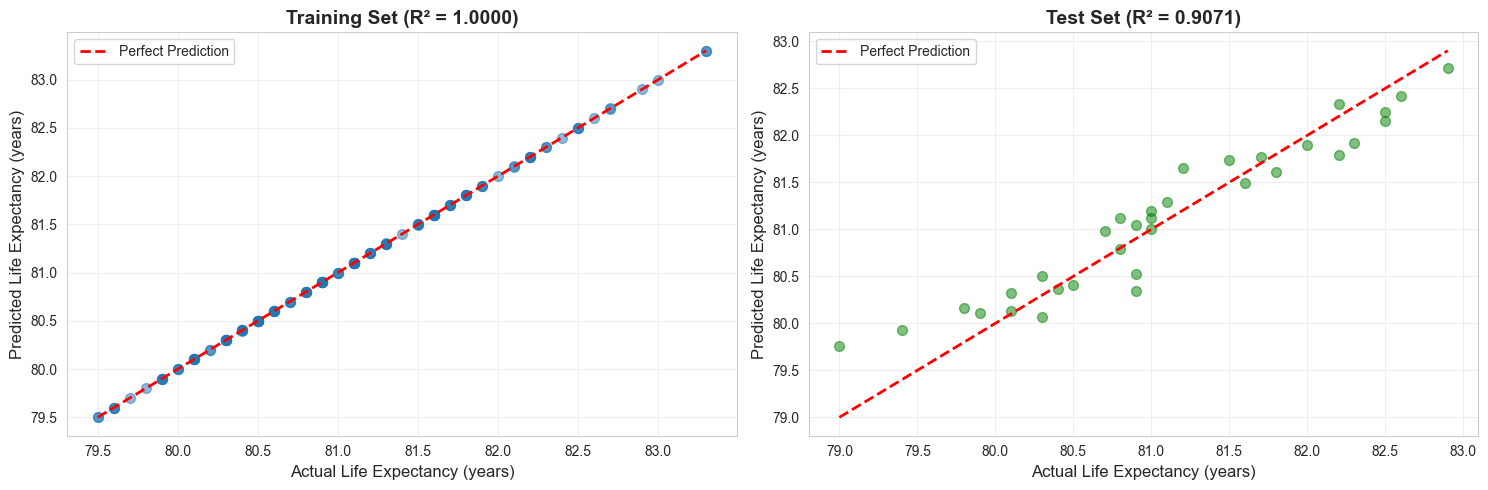

In [11]:
# Visualize predictions vs actual values
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Life Expectancy (years)', fontsize=12)
axes[0].set_ylabel('Predicted Life Expectancy (years)', fontsize=12)
axes[0].set_title(f'Training Set (R² = {train_r2:.4f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=50, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Life Expectancy (years)', fontsize=12)
axes[1].set_ylabel('Predicted Life Expectancy (years)', fontsize=12)
axes[1].set_title(f'Test Set (R² = {test_r2:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Feature Importance Analysis

This is the key section - identifying which features increase or decrease life expectancy.

In [9]:
# Get feature importance from XGBoost
# This shows which features the model uses most for predictions
feature_importance = xgb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features for Predicting Life Expectancy:")
print("=" * 70)
for idx, row in importance_df.head(20).iterrows():
    print(f"{row['Feature']:<50} {row['Importance']:.4f}")
print("=" * 70)

Top 20 Most Important Features for Predicting Life Expectancy:
1. EARNED INCOME, mean                             0.6144
disability_ratio                                   0.0563
Disposable cash income,  median                    0.0534
alcohol_sales                                      0.0353
Share of persons aged 15 or over with tertiary level qualification, % 0.0283
daily_smokers                                      0.0272
binge_drinking                                     0.0183
Average age, both sexes                            0.0160
Dwelling population, persons                       0.0153
health_workers_per_10k_public_physicians           0.0148
Population 31 Dec Pensioners                       0.0140
elder_care_per_100k                                0.0139
work_until_retired                                 0.0117
Population density                                 0.0095
incidence_disability_pension                       0.0095
Population 31 Dec Unemployed                    

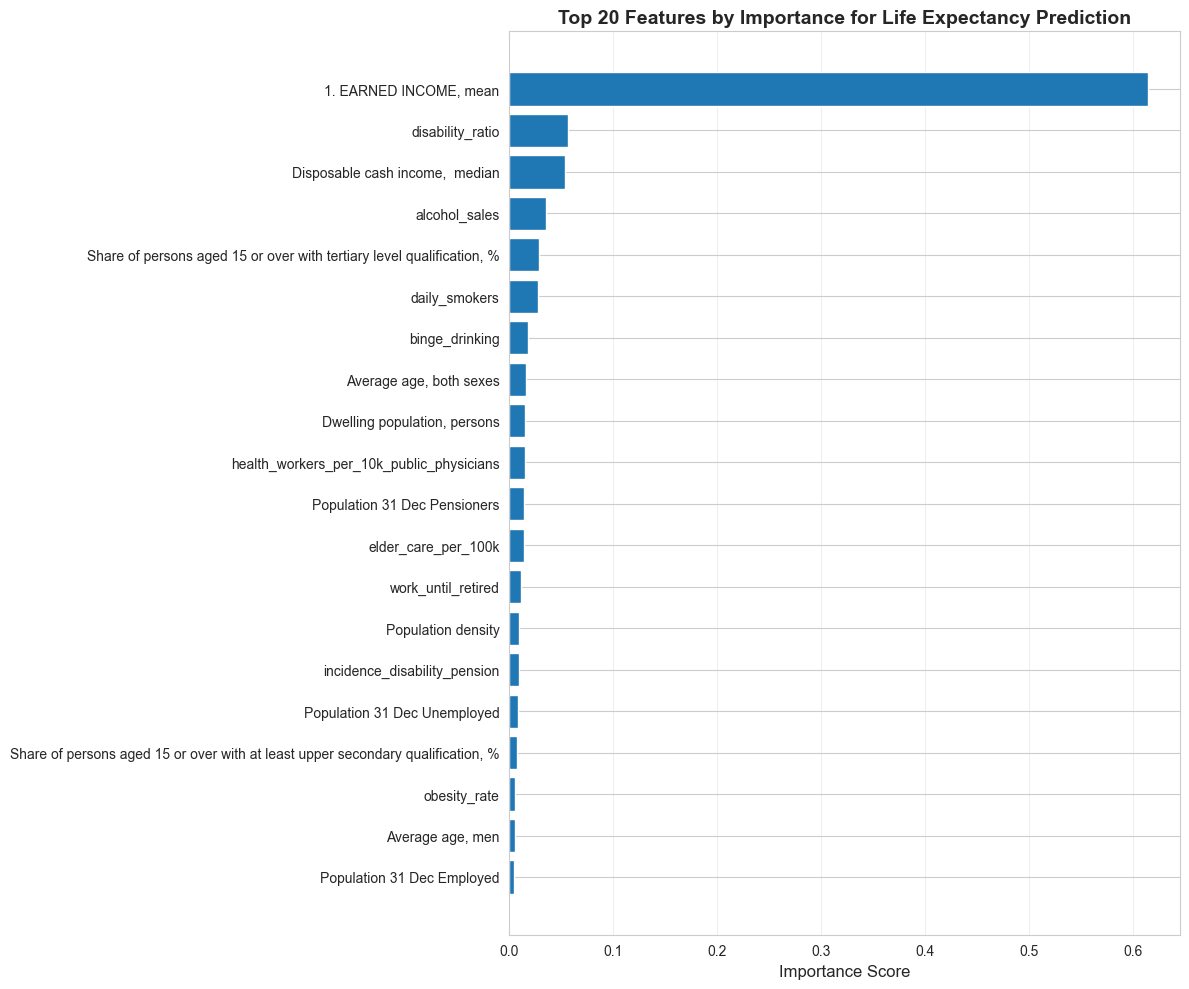

In [13]:
# Visualize feature importance
plt.figure(figsize=(12, 10))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Features by Importance for Life Expectancy Prediction', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Calculate correlations with life expectancy to determine direction of effect
# Positive correlation = feature increases life expectancy
# Negative correlation = feature decreases life expectancy
correlations = df[X.columns].corrwith(df['life_expectancy']).sort_values(ascending=False)

# Combine importance with correlation
analysis_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance,
    'Correlation': correlations[feature_names].values
})

# Add interpretation
analysis_df['Effect'] = analysis_df['Correlation'].apply(
    lambda x: 'Increases Life Expectancy' if x > 0 else 'Decreases Life Expectancy'
)

analysis_df = analysis_df.sort_values('Importance', ascending=False)

print("\n" + "=" * 90)
print("COMPLETE FEATURE ANALYSIS: Impact on Life Expectancy")
print("=" * 90)
print(f"{'Feature':<45} {'Importance':<12} {'Correlation':<12} {'Effect':<20}")
print("-" * 90)
for idx, row in analysis_df.head(25).iterrows():
    print(f"{row['Feature']:<45} {row['Importance']:<12.4f} {row['Correlation']:<12.4f} {row['Effect']:<20}")
print("=" * 90)


COMPLETE FEATURE ANALYSIS: Impact on Life Expectancy
Feature                                       Importance   Correlation  Effect              
------------------------------------------------------------------------------------------
1. EARNED INCOME, mean                        0.6144       0.6567       Increases Life Expectancy
disability_ratio                              0.0563       -0.7660      Decreases Life Expectancy
Disposable cash income,  median               0.0534       0.7342       Increases Life Expectancy
alcohol_sales                                 0.0353       -0.7076      Decreases Life Expectancy
Share of persons aged 15 or over with tertiary level qualification, % 0.0283       0.5947       Increases Life Expectancy
daily_smokers                                 0.0272       -0.4787      Decreases Life Expectancy
binge_drinking                                0.0183       -0.2512      Decreases Life Expectancy
Average age, both sexes                       0.0160

In [15]:
# Separate features that increase vs decrease life expectancy
# Filter for important features (importance > 0.01)
important_features = analysis_df[analysis_df['Importance'] > 0.01].copy()

positive_features = important_features[important_features['Correlation'] > 0].sort_values('Importance', ascending=False)
negative_features = important_features[important_features['Correlation'] < 0].sort_values('Importance', ascending=False)

print("\n" + "🟢" * 45)
print("FEATURES THAT INCREASE LIFE EXPECTANCY")
print("🟢" * 45)
print(f"{'Feature':<50} {'Importance':<12} {'Correlation':<12}")
print("-" * 75)
for idx, row in positive_features.iterrows():
    print(f"{row['Feature']:<50} {row['Importance']:<12.4f} {row['Correlation']:<12.4f}")

print("\n" + "🔴" * 45)
print("FEATURES THAT DECREASE LIFE EXPECTANCY")
print("🔴" * 45)
print(f"{'Feature':<50} {'Importance':<12} {'Correlation':<12}")
print("-" * 75)
for idx, row in negative_features.iterrows():
    print(f"{row['Feature']:<50} {row['Importance']:<12.4f} {row['Correlation']:<12.4f}")


🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢
FEATURES THAT INCREASE LIFE EXPECTANCY
🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢
Feature                                            Importance   Correlation 
---------------------------------------------------------------------------
1. EARNED INCOME, mean                             0.6144       0.6567      
Disposable cash income,  median                    0.0534       0.7342      
Share of persons aged 15 or over with tertiary level qualification, % 0.0283       0.5947      
Dwelling population, persons                       0.0153       0.2913      
health_workers_per_10k_public_physicians           0.0148       0.2990      
Population 31 Dec Pensioners                       0.0140       0.2820      

🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴
FEATURES THAT DECREASE LIFE EXPECTANCY
🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴
Feature                                            Importance   Correlation 
-------------------------

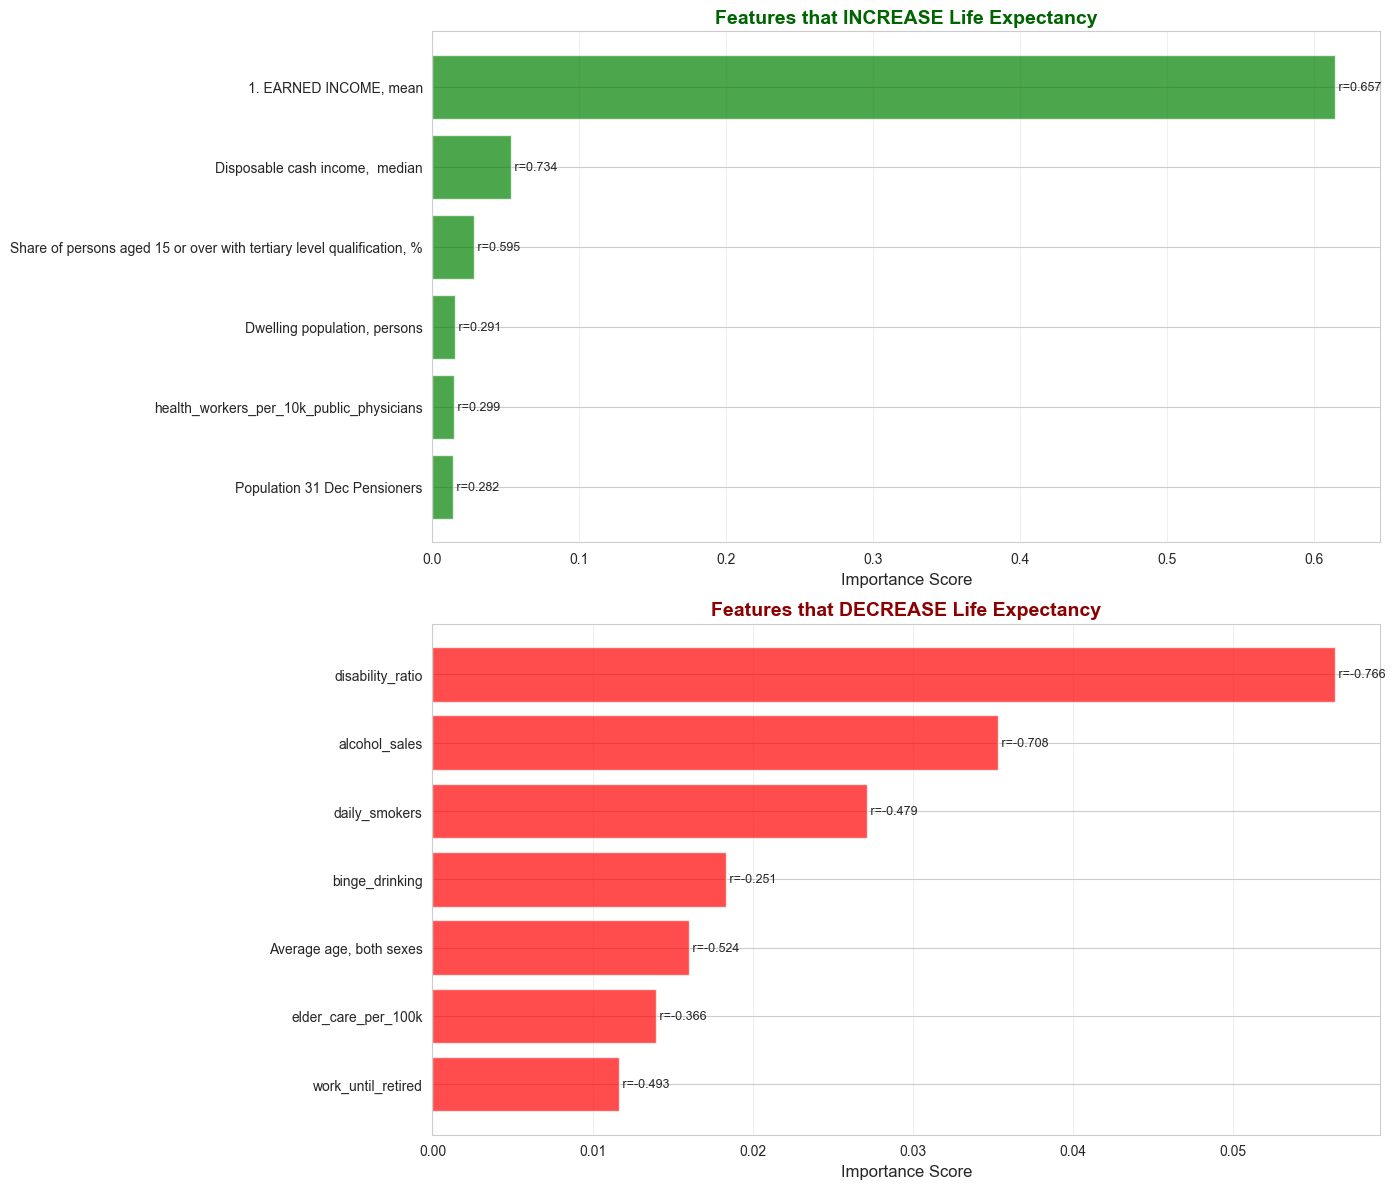

In [16]:
# Create a comprehensive visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot features that increase life expectancy
if len(positive_features) > 0:
    top_positive = positive_features.head(10)
    axes[0].barh(range(len(top_positive)), top_positive['Importance'], color='green', alpha=0.7)
    axes[0].set_yticks(range(len(top_positive)))
    axes[0].set_yticklabels(top_positive['Feature'])
    axes[0].set_xlabel('Importance Score', fontsize=12)
    axes[0].set_title('Features that INCREASE Life Expectancy', 
                      fontsize=14, fontweight='bold', color='darkgreen')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Add correlation values as text
    for i, (idx, row) in enumerate(top_positive.iterrows()):
        axes[0].text(row['Importance'], i, f" r={row['Correlation']:.3f}", 
                    va='center', fontsize=9)

# Plot features that decrease life expectancy
if len(negative_features) > 0:
    top_negative = negative_features.head(10)
    axes[1].barh(range(len(top_negative)), top_negative['Importance'], color='red', alpha=0.7)
    axes[1].set_yticks(range(len(top_negative)))
    axes[1].set_yticklabels(top_negative['Feature'])
    axes[1].set_xlabel('Importance Score', fontsize=12)
    axes[1].set_title('Features that DECREASE Life Expectancy', 
                      fontsize=14, fontweight='bold', color='darkred')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    # Add correlation values as text
    for i, (idx, row) in enumerate(top_negative.iterrows()):
        axes[1].text(row['Importance'], i, f" r={row['Correlation']:.3f}", 
                    va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6. SHAP Analysis (Advanced Feature Importance)

SHAP (SHapley Additive exPlanations) values provide more detailed insights into how features impact predictions.

In [17]:
# Install and import SHAP for advanced feature analysis
try:
    import shap
    print("SHAP library already installed")
except ImportError:
    print("Installing SHAP library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap
    print("SHAP library installed successfully")

SHAP library already installed


In [18]:
# Create SHAP explainer
print("Computing SHAP values (this may take a minute)...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)
print("SHAP values computed successfully!")

Computing SHAP values (this may take a minute)...


SHAP values computed successfully!


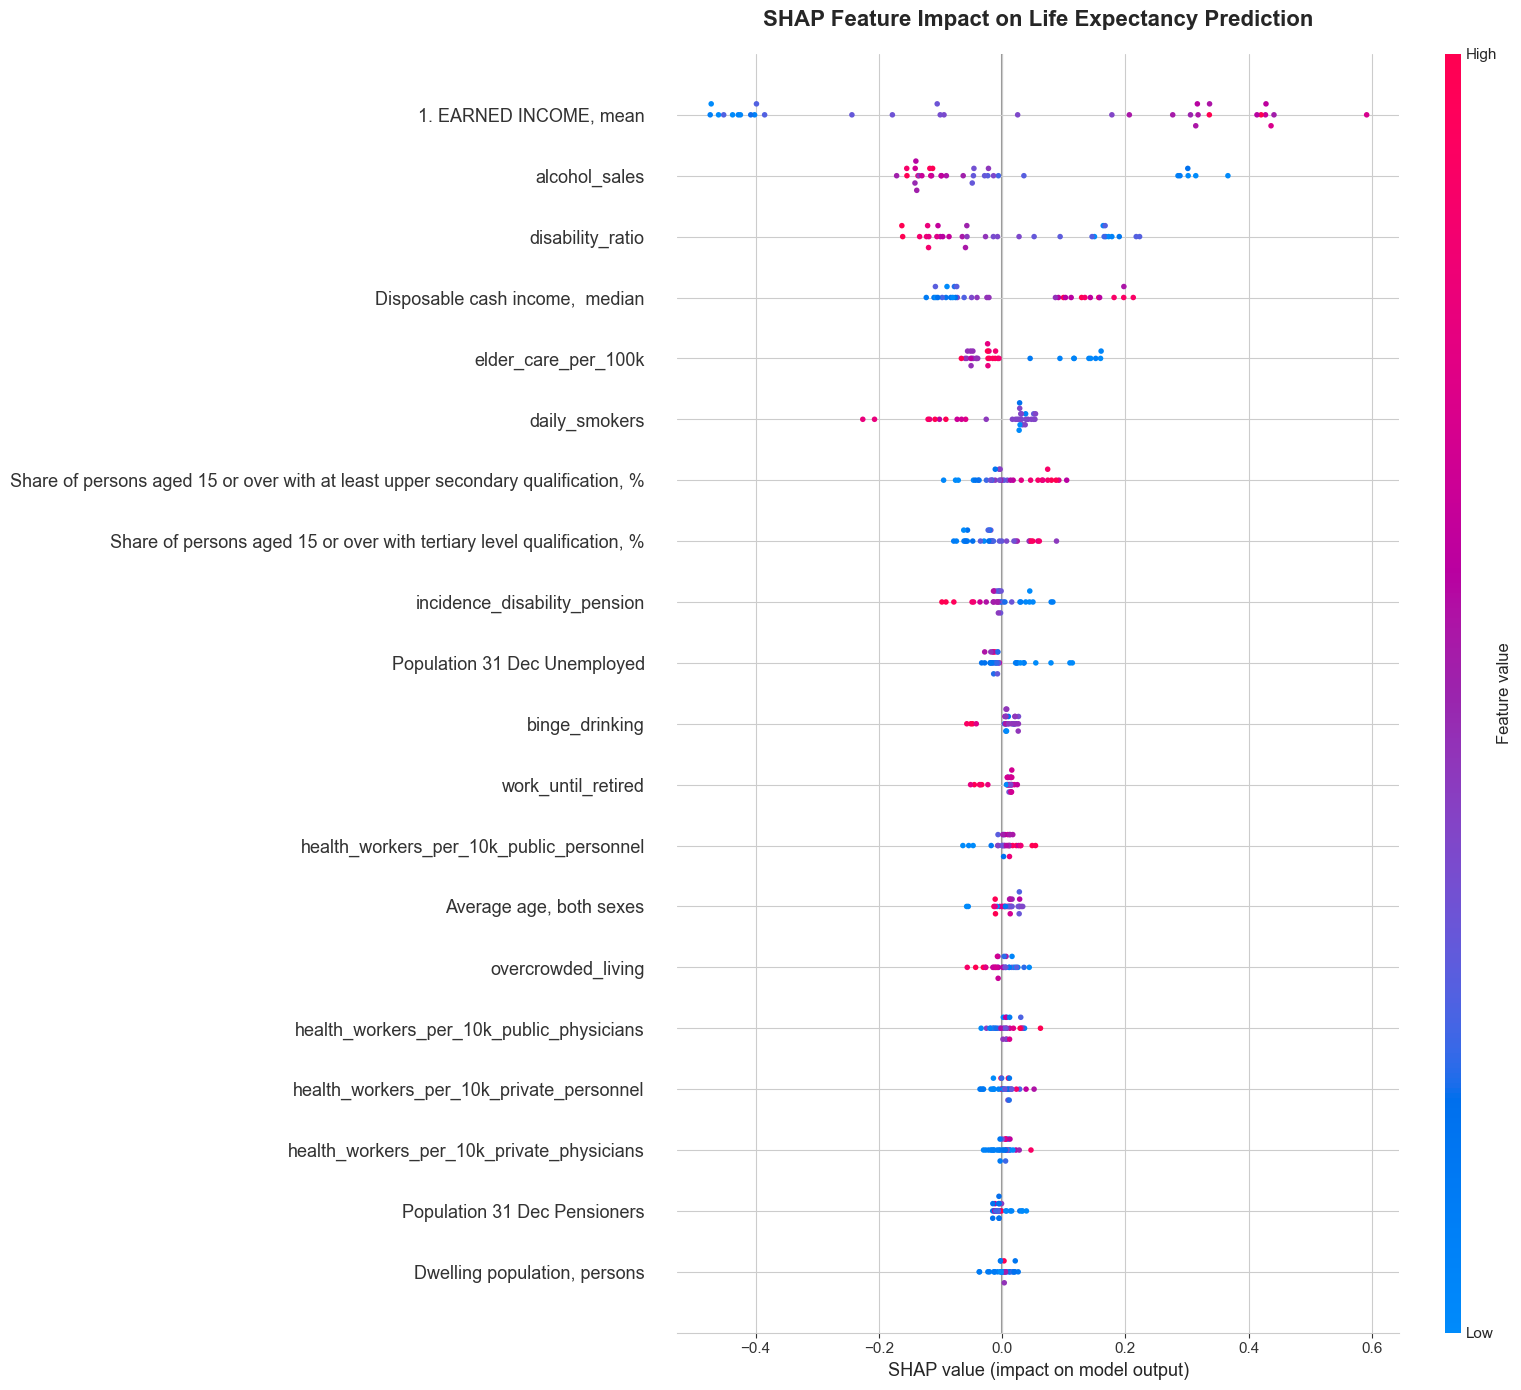


Interpretation of SHAP plot:
- Red points: High feature values
- Blue points: Low feature values
- Positive SHAP value: Increases life expectancy prediction
- Negative SHAP value: Decreases life expectancy prediction


In [27]:
# SHAP Summary Plot - shows overall impact of features
plt.figure(figsize=(16, 14))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, 
                 show=False, max_display=20, plot_size=(16, 14))
plt.title('SHAP Feature Impact on Life Expectancy Prediction', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=13)
plt.tight_layout()
plt.show()

print("\nInterpretation of SHAP plot:")
print("- Red points: High feature values")
print("- Blue points: Low feature values")
print("- Positive SHAP value: Increases life expectancy prediction")
print("- Negative SHAP value: Decreases life expectancy prediction")

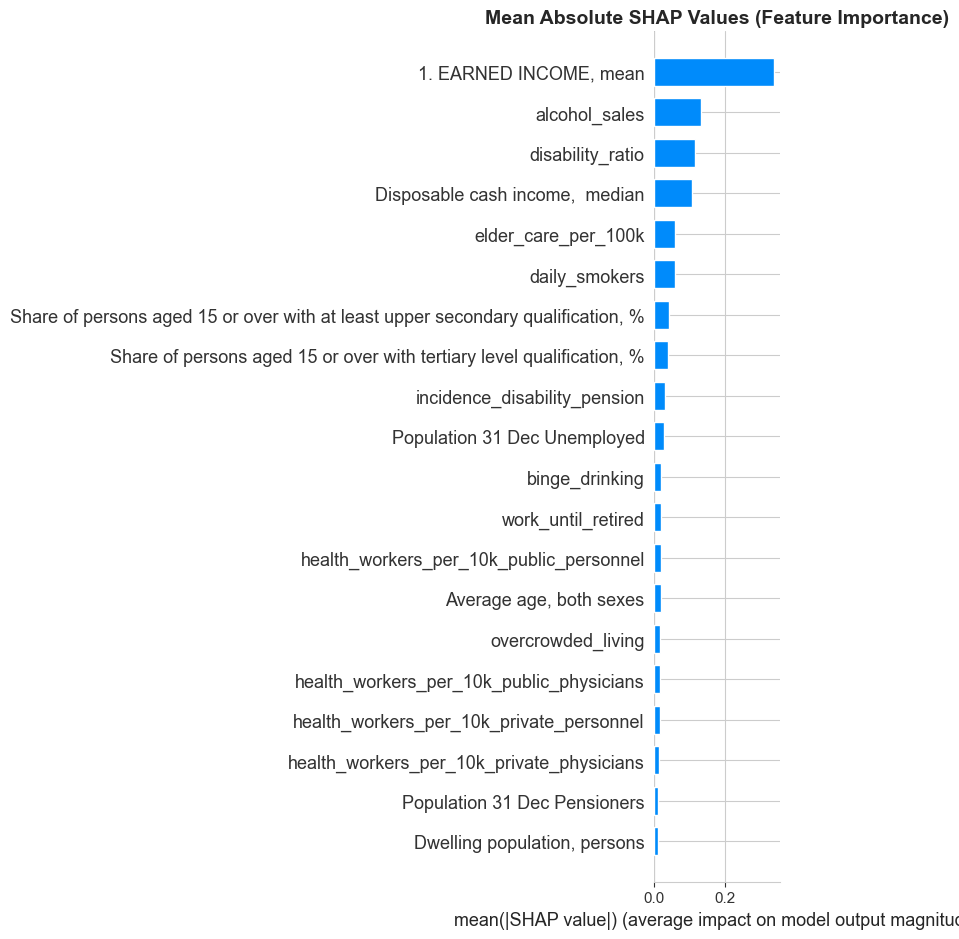

In [ ]:
# SHAP Bar Plot - shows mean absolute impact
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Full feature set
plt.sca(axes[0])
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, 
                 plot_type="bar", show=False, max_display=20)
axes[0].set_title('Top 20 Features - Mean Absolute SHAP Values', fontsize=14, fontweight='bold')
axes[0].set_xlabel('mean(|SHAP value|)', fontsize=12)

# Top 10 features with better spacing
plt.sca(axes[1])
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, 
                 plot_type="bar", show=False, max_display=10)
axes[1].set_title('Top 10 Features - Detailed View', fontsize=14, fontweight='bold')
axes[1].set_xlabel('mean(|SHAP value|)', fontsize=12)

plt.tight_layout()
plt.show()

print("\nNote: Larger bars indicate features with greater impact on predictions")

## 7. Summary and Key Findings

In [21]:
# Create summary report
print("=" * 80)
print("LIFE EXPECTANCY PREDICTION MODEL - SUMMARY REPORT")
print("=" * 80)
print(f"\n📊 MODEL PERFORMANCE:")
print(f"   • Test R² Score: {test_r2:.4f} ({test_r2*100:.2f}% variance explained)")
print(f"   • Test RMSE: {test_rmse:.4f} years")
print(f"   • Test MAE: {test_mae:.4f} years")
print(f"\n📈 MODEL INSIGHTS:")
print(f"   • Total features analyzed: {len(X.columns)}")
print(f"   • Important features (>1% importance): {len(important_features)}")
print(f"   • Features that increase life expectancy: {len(positive_features)}")
print(f"   • Features that decrease life expectancy: {len(negative_features)}")

print(f"\n🟢 TOP 5 FEATURES THAT INCREASE LIFE EXPECTANCY:")
for i, (idx, row) in enumerate(positive_features.head(5).iterrows(), 1):
    print(f"   {i}. {row['Feature']}")
    print(f"      → Importance: {row['Importance']:.4f}, Correlation: {row['Correlation']:.4f}")

print(f"\n🔴 TOP 5 FEATURES THAT DECREASE LIFE EXPECTANCY:")
for i, (idx, row) in enumerate(negative_features.head(5).iterrows(), 1):
    print(f"   {i}. {row['Feature']}")
    print(f"      → Importance: {row['Importance']:.4f}, Correlation: {row['Correlation']:.4f}")

print("\n" + "=" * 80)
print("💡 RECOMMENDATIONS:")
print("=" * 80)
print("Based on this analysis, to increase life expectancy in a region:")
print("\n✅ INCREASE:")
for i, (idx, row) in enumerate(positive_features.head(3).iterrows(), 1):
    print(f"   • {row['Feature'].replace('_', ' ').title()}")

print("\n❌ DECREASE:")
for i, (idx, row) in enumerate(negative_features.head(3).iterrows(), 1):
    print(f"   • {row['Feature'].replace('_', ' ').title()}")
print("=" * 80)

LIFE EXPECTANCY PREDICTION MODEL - SUMMARY REPORT

📊 MODEL PERFORMANCE:
   • Test R² Score: 0.9071 (90.71% variance explained)
   • Test RMSE: 0.2926 years
   • Test MAE: 0.2399 years

📈 MODEL INSIGHTS:
   • Total features analyzed: 34
   • Important features (>1% importance): 13
   • Features that increase life expectancy: 6
   • Features that decrease life expectancy: 7

🟢 TOP 5 FEATURES THAT INCREASE LIFE EXPECTANCY:
   1. 1. EARNED INCOME, mean
      → Importance: 0.6144, Correlation: 0.6567
   2. Disposable cash income,  median
      → Importance: 0.0534, Correlation: 0.7342
   3. Share of persons aged 15 or over with tertiary level qualification, %
      → Importance: 0.0283, Correlation: 0.5947
   4. Dwelling population, persons
      → Importance: 0.0153, Correlation: 0.2913
   5. health_workers_per_10k_public_physicians
      → Importance: 0.0148, Correlation: 0.2990

🔴 TOP 5 FEATURES THAT DECREASE LIFE EXPECTANCY:
   1. disability_ratio
      → Importance: 0.0563, Correlation

In [22]:
# Export results to CSV for further analysis
results_df = analysis_df.copy()
results_df['Direction'] = results_df['Correlation'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
results_df = results_df.sort_values('Importance', ascending=False)

output_file = 'life_expectancy_feature_analysis.csv'
results_df.to_csv(output_file, index=False)
print(f"\n📁 Full analysis saved to: {output_file}")

# Show top results
print("\nSample of exported data:")
print(results_df.head(10).to_string(index=False))


📁 Full analysis saved to: life_expectancy_feature_analysis.csv

Sample of exported data:
                                                              Feature  Importance  Correlation                    Effect Direction
                                               1. EARNED INCOME, mean    0.614359     0.656682 Increases Life Expectancy  Positive
                                                     disability_ratio    0.056345    -0.765965 Decreases Life Expectancy  Negative
                                      Disposable cash income,  median    0.053444     0.734164 Increases Life Expectancy  Positive
                                                        alcohol_sales    0.035315    -0.707598 Decreases Life Expectancy  Negative
Share of persons aged 15 or over with tertiary level qualification, %    0.028328     0.594746 Increases Life Expectancy  Positive
                                                        daily_smokers    0.027155    -0.478655 Decreases Life Expectancy  Ne

## 8. Individual Life Expectancy Prediction

Use the trained model to predict life expectancy for individuals based on their personal attributes.

In [28]:
def predict_life_expectancy(individual_data, show_details=True):
    """
    Predict life expectancy for an individual based on their attributes.
    
    Parameters:
    -----------
    individual_data : dict
        Dictionary containing individual's attributes matching the feature names
    show_details : bool
        Whether to show detailed breakdown of predictions
        
    Returns:
    --------
    float : Predicted life expectancy in years
    """
    # Create DataFrame from individual data
    individual_df = pd.DataFrame([individual_data])
    
    # Ensure all features are present
    missing_features = set(X.columns) - set(individual_df.columns)
    if missing_features:
        print(f"⚠️  Warning: Missing features: {missing_features}")
        print("Using dataset median values for missing features...")
        for feature in missing_features:
            individual_df[feature] = df[feature].median()
    
    # Reorder columns to match training data
    individual_df = individual_df[X.columns]
    
    # Scale the features using the same scaler
    individual_scaled = scaler.transform(individual_df)
    
    # Make prediction
    predicted_life_expectancy = xgb_model.predict(individual_scaled)[0]
    
    if show_details:
        print("=" * 80)
        print("🔮 LIFE EXPECTANCY PREDICTION")
        print("=" * 80)
        print(f"\n📊 Predicted Life Expectancy: {predicted_life_expectancy:.2f} years")
        
        # Compare to dataset statistics
        mean_le = y.mean()
        std_le = y.std()
        percentile = ((y < predicted_life_expectancy).sum() / len(y)) * 100
        
        print(f"\n📈 Comparison to Dataset:")
        print(f"   • Dataset Average: {mean_le:.2f} years")
        print(f"   • Your Prediction: {predicted_life_expectancy:.2f} years")
        print(f"   • Difference: {predicted_life_expectancy - mean_le:+.2f} years")
        print(f"   • Percentile: {percentile:.1f}th percentile")
        
        if predicted_life_expectancy > mean_le:
            print(f"   ✅ Above average by {predicted_life_expectancy - mean_le:.2f} years")
        else:
            print(f"   ⚠️  Below average by {abs(predicted_life_expectancy - mean_le):.2f} years")
        
        print("=" * 80)
    
    return predicted_life_expectancy

print("✅ Prediction function created successfully!")
print("\nFunction: predict_life_expectancy(individual_data, show_details=True)")
print("\nRequired features:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

✅ Prediction function created successfully!

Function: predict_life_expectancy(individual_data, show_details=True)

Required features:
  1. overcrowded_living
  2. alcohol_sales
  3. health_workers_per_10k_private_personnel
  4. health_workers_per_10k_private_physicians
  5. health_workers_per_10k_public_personnel
  6. health_workers_per_10k_public_physicians
  7. daily_smokers
  8. obesity_rate
  9. regular_sports_events
  10. binge_drinking
  11. incidence_disability_pension
  12. physical_activity
  13. percentage_happy
  14. disability_ratio
  15. elder_care_per_100k
  16. severe_mental_strain
  17. work_until_retired
  18. mental_health
  19. Average age, both sexes
  20. Average age, men
  21. Average age, women
  22. Population density
  23. Share of persons in rural areas, %
  24. Share of persons in urban areas, %
  25. 1. EARNED INCOME, mean
  26. Disposable cash income,  median
  27. Dwelling population, persons
  28. Share of persons aged 15 or over with at least upper seco

### Example 1: High-Risk Individual

Let's predict life expectancy for someone with unhealthy lifestyle factors.

In [29]:
# Example: Individual with higher risk factors
high_risk_individual = {
    'overcrowded_living': 12.0,                    # Higher overcrowding
    'alcohol_sales': 10.0,                          # High alcohol consumption
    'daily_smokers': 18.0,                          # High smoking rate
    'obesity_rate': 25.0,                           # High obesity
    'binge_drinking': 15.0,                         # High binge drinking
    'disability_ratio': 12.0,                       # High disability
    'severe_mental_strain': 15.0,                   # High mental strain
    '1. EARNED INCOME, mean': 25000.0,              # Low income
    'Disposable cash income,  median': 30000.0,     # Low disposable income
    'Share of persons aged 15 or over with tertiary level qualification, %': 20.0,  # Low education
    'physical_activity': 18.0,                      # Low physical activity
    'percentage_happy': 45.0,                       # Low happiness
}

print("🔴 HIGH-RISK INDIVIDUAL PROFILE:")
print("   • High alcohol consumption and smoking")
print("   • Low income and education")
print("   • High obesity and low physical activity")
print("   • High mental strain\n")

high_risk_prediction = predict_life_expectancy(high_risk_individual)

🔴 HIGH-RISK INDIVIDUAL PROFILE:
   • High alcohol consumption and smoking
   • Low income and education
   • High obesity and low physical activity
   • High mental strain

⚠️  Warning: Missing features: {'Share of persons aged 15 or over without upper secondary qualification, %, %', 'incidence_disability_pension', 'Average age, both sexes', 'Share of persons in urban areas, %', 'Population 31 Dec Pensioners', 'health_workers_per_10k_public_physicians', 'health_workers_per_10k_public_personnel', 'regular_sports_events', 'elder_care_per_100k', 'Population 31 Dec Unemployed', 'Population 31 Dec Other persons outside the labour force', 'mental_health', 'health_workers_per_10k_private_personnel', 'work_until_retired', 'Population 31 Dec Employed', 'Share of persons in rural areas, %', 'Average age, men', 'health_workers_per_10k_private_physicians', 'Average age, women', 'Dwelling population, persons', 'Population density', 'Share of persons aged 15 or over with at least upper secondary qua

### Example 2: Healthy Individual

Let's predict life expectancy for someone with healthy lifestyle factors.

In [30]:
# Example: Individual with protective factors
healthy_individual = {
    'overcrowded_living': 5.0,                      # Low overcrowding
    'alcohol_sales': 6.0,                           # Moderate alcohol
    'daily_smokers': 8.0,                           # Low smoking rate
    'obesity_rate': 15.0,                           # Low obesity
    'binge_drinking': 7.0,                          # Low binge drinking
    'disability_ratio': 6.0,                        # Low disability
    'severe_mental_strain': 8.0,                    # Low mental strain
    '1. EARNED INCOME, mean': 40000.0,              # High income
    'Disposable cash income,  median': 42000.0,     # High disposable income
    'Share of persons aged 15 or over with tertiary level qualification, %': 35.0,  # High education
    'physical_activity': 28.0,                      # High physical activity
    'percentage_happy': 60.0,                       # High happiness
}

print("🟢 HEALTHY INDIVIDUAL PROFILE:")
print("   • Low alcohol consumption and smoking")
print("   • High income and education")
print("   • Low obesity and high physical activity")
print("   • Low mental strain\n")

healthy_prediction = predict_life_expectancy(healthy_individual)

🟢 HEALTHY INDIVIDUAL PROFILE:
   • Low alcohol consumption and smoking
   • High income and education
   • Low obesity and high physical activity
   • Low mental strain

⚠️  Warning: Missing features: {'Share of persons aged 15 or over without upper secondary qualification, %, %', 'incidence_disability_pension', 'Average age, both sexes', 'Share of persons in urban areas, %', 'Population 31 Dec Pensioners', 'health_workers_per_10k_public_physicians', 'health_workers_per_10k_public_personnel', 'regular_sports_events', 'elder_care_per_100k', 'Population 31 Dec Unemployed', 'Population 31 Dec Other persons outside the labour force', 'mental_health', 'health_workers_per_10k_private_personnel', 'work_until_retired', 'Population 31 Dec Employed', 'Share of persons in rural areas, %', 'Average age, men', 'health_workers_per_10k_private_physicians', 'Average age, women', 'Dwelling population, persons', 'Population density', 'Share of persons aged 15 or over with at least upper secondary qualif

### Compare the Two Profiles

📊 COMPARISON: HIGH-RISK vs HEALTHY INDIVIDUAL

🔴 High-Risk Individual: 80.11 years
🟢 Healthy Individual:   82.25 years

💡 Difference: 2.15 years
   The healthy lifestyle could add 2.15 years to life expectancy!



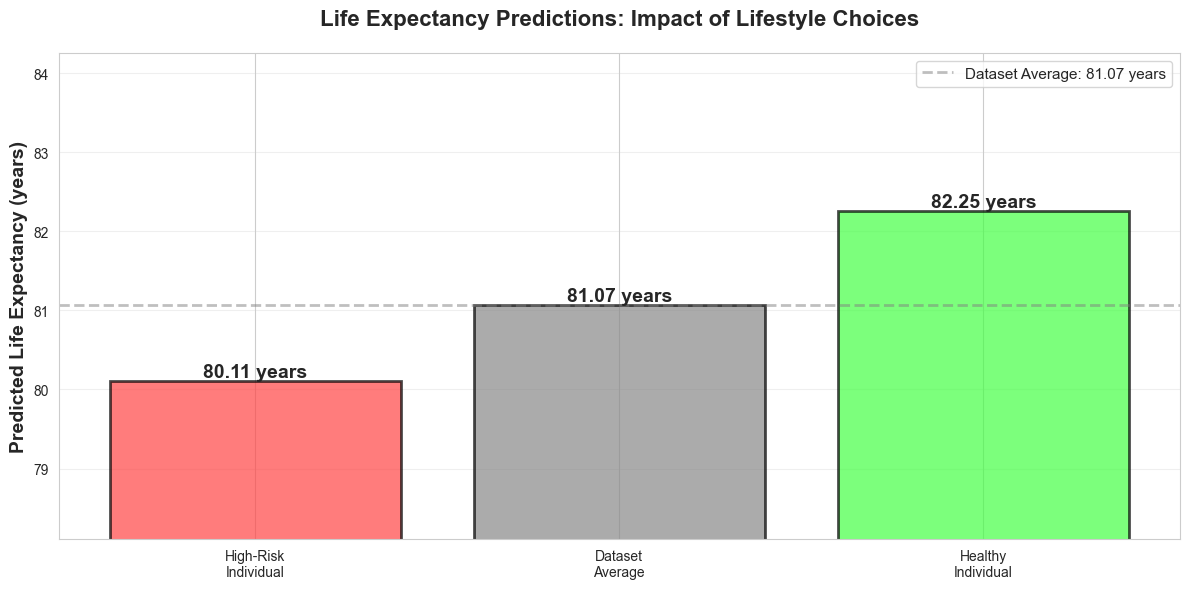

In [31]:
# Compare the two predictions
print("=" * 80)
print("📊 COMPARISON: HIGH-RISK vs HEALTHY INDIVIDUAL")
print("=" * 80)
print(f"\n🔴 High-Risk Individual: {high_risk_prediction:.2f} years")
print(f"🟢 Healthy Individual:   {healthy_prediction:.2f} years")
print(f"\n💡 Difference: {healthy_prediction - high_risk_prediction:.2f} years")
print(f"   The healthy lifestyle could add {healthy_prediction - high_risk_prediction:.2f} years to life expectancy!")
print("\n" + "=" * 80)

# Visualize the comparison
fig, ax = plt.subplots(figsize=(12, 6))

profiles = ['High-Risk\nIndividual', 'Dataset\nAverage', 'Healthy\nIndividual']
predictions = [high_risk_prediction, y.mean(), healthy_prediction]
colors = ['#ff4444', '#888888', '#44ff44']

bars = ax.bar(profiles, predictions, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, pred in zip(bars, predictions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pred:.2f} years',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=14, fontweight='bold')
ax.set_title('Life Expectancy Predictions: Impact of Lifestyle Choices', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylim([min(predictions) - 2, max(predictions) + 2])
ax.grid(axis='y', alpha=0.3)

# Add horizontal line for dataset average
ax.axhline(y=y.mean(), color='gray', linestyle='--', linewidth=2, alpha=0.5, 
           label=f'Dataset Average: {y.mean():.2f} years')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

### Create Your Own Prediction

Use the template below to predict life expectancy for any individual by filling in their attributes.

In [ ]:
# Template for custom prediction
# Fill in the values below with your own data
your_data = {
    # MOST IMPORTANT FEATURES (from our analysis):
    '1. EARNED INCOME, mean': 35000.0,              # Annual income in euros
    'Disposable cash income,  median': 38000.0,     # Disposable income in euros
    'disability_ratio': 8.0,                        # Percentage with disabilities
    'alcohol_sales': 7.5,                           # Alcohol sales per capita
    'Share of persons aged 15 or over with tertiary level qualification, %': 28.0,
    
    # LIFESTYLE FACTORS:
    'daily_smokers': 13.0,                          # Percentage who smoke daily
    'binge_drinking': 10.0,                         # Percentage who binge drink
    'obesity_rate': 20.0,                           # Obesity rate percentage
    'physical_activity': 24.0,                      # Physical activity level
    
    # HEALTH & WELLBEING:
    'percentage_happy': 52.0,                       # Percentage reporting happiness
    'severe_mental_strain': 11.0,                   # Percentage with mental strain
    'mental_health': 120.0,                         # Mental health index
    
    # HEALTHCARE ACCESS:
    'health_workers_per_10k_public_physicians': 20.0,
    'health_workers_per_10k_private_physicians': 4.0,
    
    # OTHER FACTORS:
    'overcrowded_living': 8.0,                      # Percentage in overcrowded housing
    'elder_care_per_100k': 2800.0,                  # Elder care availability
    'work_until_retired': 28.0,                     # Years worked until retirement
}

print("📋 YOUR CUSTOM PREDICTION:")
print("=" * 80)
print("\nKey Attributes Provided:")
print(f"  • Income: €{your_data['1. EARNED INCOME, mean']:,.0f}")
print(f"  • Daily Smokers: {your_data['daily_smokers']}%")
print(f"  • Alcohol Sales: {your_data['alcohol_sales']}")
print(f"  • Physical Activity: {your_data['physical_activity']}%")
print(f"  • Tertiary Education: {your_data['Share of persons aged 15 or over with tertiary level qualification, %']}%")
print("\n")

your_prediction = predict_life_expectancy(your_data)

print("\n💡 TIP: Modify the values above and re-run this cell to see how")
print("   different attributes affect life expectancy predictions!")

## 9. Export Model and Scaler for Web Application

Export the trained model, scaler, and feature information for use in the web application backend.

In [11]:
import pickle
import json
import os

# Create directory for web app model files
model_dir = 'webapp_model'
os.makedirs(model_dir, exist_ok=True)

# 1. Save the trained XGBoost model
model_path = os.path.join(model_dir, 'model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"✅ Model saved to: {model_path}")

# 2. Save the StandardScaler
scaler_path = os.path.join(model_dir, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler saved to: {scaler_path}")

# 3. Save feature names and metadata
feature_info = {
    'feature_names': list(X.columns),
    'n_features': len(X.columns),
    'feature_medians': df[X.columns].median().to_dict(),
    'target_mean': float(y.mean()),
    'target_std': float(y.std()),
    'target_min': float(y.min()),
    'target_max': float(y.max())
}

feature_info_path = os.path.join(model_dir, 'feature_info.json')
with open(feature_info_path, 'w') as f:
    json.dump(feature_info, f, indent=2)
print(f"✅ Feature info saved to: {feature_info_path}")

# 4. Save the feature analysis results for the web app
top_features_df = analysis_df.head(10).copy()
top_features_dict = {
    'top_features': top_features_df.to_dict('records')
}

top_features_path = os.path.join(model_dir, 'top_features.json')
with open(top_features_path, 'w') as f:
    json.dump(top_features_dict, f, indent=2)
print(f"✅ Top features saved to: {top_features_path}")

print("\n" + "="*60)
print("🎉 All model files exported successfully!")
print("="*60)
print(f"\nFiles created in '{model_dir}' directory:")
print(f"  1. model.pkl - Trained XGBoost model")
print(f"  2. scaler.pkl - Feature StandardScaler")
print(f"  3. feature_info.json - Feature metadata and medians")
print(f"  4. top_features.json - Top 10 important features")
print("\nThese files are ready to be used in the web application backend.")
print("="*60)

✅ Model saved to: webapp_model/model.pkl
✅ Scaler saved to: webapp_model/scaler.pkl
✅ Feature info saved to: webapp_model/feature_info.json
✅ Top features saved to: webapp_model/top_features.json

🎉 All model files exported successfully!

Files created in 'webapp_model' directory:
  1. model.pkl - Trained XGBoost model
  2. scaler.pkl - Feature StandardScaler
  3. feature_info.json - Feature metadata and medians
  4. top_features.json - Top 10 important features

These files are ready to be used in the web application backend.
